In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                  torchvision.transforms.Grayscale(3), 
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                  torchvision.transforms.Grayscale(3) ,
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [2]:
class JacobianReg(nn.Module):
    '''
    Loss criterion that computes the trace of the square of the Jacobian.
    Arguments:
        n (int, optional): determines the number of random projections.
            If n=-1, then it is set to the dimension of the output 
            space and projection is non-random and orthonormal, yielding 
            the exact result.  For any reasonable batch size, the default 
            (n=1) should be sufficient.
    '''
    def __init__(self, n=1):
        assert n == -1 or n > 0
        self.n = n
        super(JacobianReg, self).__init__()

    def forward(self, x, y):
        '''
        computes (1/2) tr |dy/dx|^2
        '''
        B,C = y.shape
        if self.n == -1:
            num_proj = C
        else:
            num_proj = self.n
        J2 = 0
        for ii in range(num_proj):
            if self.n == -1:
                # orthonormal vector, sequentially spanned
                v=torch.zeros(B,C)
                v[:,ii]=1
            else:
                # random properly-normalized vector for each sample
                v = self._random_vector(C=C,B=B)
            if x.is_cuda:
                v = v.cuda()
                
            #print(y.requires_grad)
            #print(x.requires_grad)
            #print(v.requires_grad)
            Jv = self._jacobian_vector_product(y, x, v, create_graph=True)
            J2 += C*torch.norm(Jv)**2 / (num_proj*B)
        R = (1/2)*J2
        return R

    def _random_vector(self, C, B):
        '''
        creates a random vector of dimension C with a norm of C^(1/2)
        (as needed for the projection formula to work)
        '''
        if C == 1: 
            return torch.ones(B)
        v=torch.randn(B,C)
        arxilirary_zero=torch.zeros(B,C)
        vnorm=torch.norm(v, 2, 1,True)
        v=torch.addcdiv(arxilirary_zero, 1.0, v, vnorm)
        return v
                                                                            
    def _jacobian_vector_product(self, y, x, v, create_graph=False): 
        '''
        Produce jacobian-vector product dy/dx dot v.
        Note that if you want to differentiate it,
        you need to make create_graph=True
        '''                                                            
        flat_y = y.reshape(-1)
        flat_v = v.reshape(-1)
        grad_x, = torch.autograd.grad(flat_y, x, flat_v, 
                                        retain_graph=True, 
                                        create_graph=create_graph)
        return grad_x

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc = nn.Linear(10000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(F.relu(x))
        return x

In [14]:

def accuracy(model, dataloader, device):
  with torch.no_grad():
    correct = 0
    total = 0
    model.eval()
    for i, data in (enumerate(dataloader)):
      image, label = data
      image = image.to(device)
      label = label.to(device)
      outputs = model(image)
      probs = F.softmax(outputs, dim=1)
      preds = torch.argmax(probs, dim=1)
      correct += torch.sum(preds==label)
      total += label.size(0)
    _ = model.train()
    return correct * 100.0 / total

def train_model(model, criterion, optimizer, trainloader, 
                testloader, num_epochs , withJacoReg = False):
  for epoch in range(num_epochs+1):
    for i, data in (enumerate(trainloader)):
        image, label = data
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True # this is essential!

        optimizer.zero_grad()
        
        outputs = model(image)
            
        if(withJacoReg):
            loss_super = criterion(outputs, label)
            R = reg(image, outputs)   # Jacobian regularization
            loss = loss_super + lambda_JR*R # full loss
        else: #without Jacobian regularizar
            loss_super = criterion(outputs, label)
            loss= loss_super

        
        
        loss.backward()
        optimizer.step()
    train_accuracy = accuracy(model, trainloader, device)
    print("Training loss: %.2f, Training accuracy %.2f"%(loss.item(), train_accuracy))

In [15]:
MnistNet = Net()
#MnistNet.load_state_dict(torch.load("./basic_mnist2.pt"))
optimizer = optim.Adam(MnistNet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
reg = JacobianReg() # Jacobian regularization
lambda_JR = 0.01 # hyperparameter
device = torch.device('cuda:0')

MnistNet.to(device)
criterion.to(device)

print("Number of parameter is %d"%(sum([p.numel() for p in MnistNet.parameters()])) )

#trainwithJaco = False
trainwithJaco = True

train_model(MnistNet, criterion, optimizer, train_loader, test_loader, num_epochs=5, withJacoReg=trainwithJaco)


Number of parameter is 100458
Training loss: 0.22, Training accuracy 94.96
Training loss: 0.20, Training accuracy 97.14
Training loss: 0.23, Training accuracy 96.90
Training loss: 0.06, Training accuracy 97.22
Training loss: 0.09, Training accuracy 97.11
Training loss: 0.11, Training accuracy 97.55


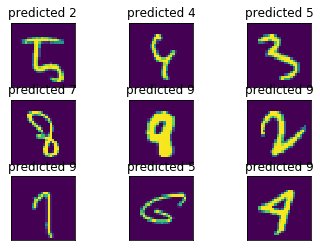

In [16]:
wrong_images = []
predictions = []
MnistNet.eval()

with torch.no_grad():
  for i, data in enumerate(test_loader):
    image, label = data
    image = image.to(device)
    label = label.to(device)
    outputs = MnistNet(image)
    
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1)
    mask = ~(pred==label)
    wrong_images.append(image[mask,:,:,:].detach().cpu().numpy())
    predictions.append(pred[mask].detach().cpu().numpy())

wrong_images = np.concatenate(wrong_images, axis=0)
predictions = np.concatenate(predictions, axis=0)
wrong_images_9 = wrong_images[:10,:,:,:]
predictions_9 = predictions[:10]

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3)

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(wrong_images_9[i][0])
  plt.title('predicted '+str(predictions_9[i]))
  plt.xticks([])
  plt.yticks([])

In [17]:
if(trainwithJaco):
    torch.save(MnistNet.state_dict(), "./models/jb_mnist.pt") 
else:
    torch.save(MnistNet.state_dict(), "./models/basic_mnist.pt") 

In [ ]:
for i, data in enumerate(test_loader):
    image, label = data
    imwrite()